Here we would compare between Batch EM and Stochastic EM by doing clustering on MNIST dataset

In [2]:
# Global Imports and Settings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [6.0, 6.0]

In [3]:
# Data Loading
mnist = loadmat('mnist_small.mat')
mnist_x = mnist['X']
np.random.shuffle(mnist_x)

## Utility Functions

This section defines utility functions for calculating softmax, logarithm of a Gaussian PDF and a utility to plot the cluster means as images which we use later. All operations are appropriately vectorized. The softmax uses the numerical stability trick given in the sample MATLAB code

In [4]:
def softmax(x):
    ex = np.exp(x - np.expand_dims(x.max(axis=1), axis=1))
    return ex / np.expand_dims(np.sum(ex, axis=1), axis=1)

In [5]:
def log_gauss(x, mean, var):
    D = x.shape[1]
    return -(D / 2) * np.log(2 * np.pi * var) - (np.sum((x - mean) ** 2, axis=1)) / (2 * var)

In [6]:
def plot_images(cluster_means, shape):
    num_img = cluster_means.shape[0]
    f, axes = plt.subplots(*shape)
    plt.title('Cluster Mean Images for {} clusters'.format(num_img))
    axes = axes.flat
    for i in range(len(axes)):
        axes[i].set_title('Cluster {}'.format(i+1))
        axes[i].imshow(np.reshape(cluster_means[i], (28, 28)), interpolation='nearest', cmap='gray')
        axes[i].axis('off')

## Batch EM Algorithm

This section implements the batch EM algorithm for the GMM. The cluster means and variances are initialized by multiplying the empirical mean and variance of the entire dataset with a uniform random factor ranging from 0 to 3 and 2 to 3 respectively. 
The cluster probabilities are initialized by random sampling the unnormalized log probabilities then normalizing them appropriately

The dataset is randomly shuffled to make sure the same type of examples are not seen in a continued sequence


In [7]:
def batch_em_gmm(dataset, num_clusters=5, num_itr=200, logging=True):
    # Shuffle the data
    X = dataset
    np.random.shuffle(X)
    num_data, data_dim = X.shape
    
    assert num_clusters <= num_data
    
    # Initialize Cluster Means, Variances and cluster probabilities
    data_mean = np.mean(dataset, axis=0)
    data_var = np.var(dataset)
    
    cluster_means = np.array([data_mean * 3 * np.random.rand(784) for i in range(num_clusters)])
    global_variance = data_var * (2 + np.random.rand(1))
    cluster_prob = np.exp(np.array([10 * np.random.rand(1) for i in range(num_clusters)]))
    cluster_prob /= np.sum(cluster_prob)
    
    cll_logs = []
    for itr in range(num_itr):
        # E Step: Calculate the required probability gamma_nk = p(c_n = k | theta, x_n) where c_n is the cluster assignment of x_n
        log_gammas = np.zeros((num_clusters, num_data))
        for k in range(num_clusters):
            log_gammas[k] = log_gauss(X, cluster_means[k], global_variance) + np.log(cluster_prob[k])
        gammas = softmax(log_gammas.T)
        sum_gammas = np.sum(gammas, axis=0, keepdims=True).T
        
        # M Step : Parameter Estimation of cluster probabilities Pi_k using gamma_nk
        cluster_prob = sum_gammas / num_data
        gammas = gammas.T
        
        # M Step : Parameter Estimation of cluster means mu_k and the global / shared variance sigma_k
        global_variance = 0.0
        for k in range(num_clusters):
            gamma_k = np.expand_dims(gammas[k], axis=1)
            cluster_means[k] = np.sum(gamma_k * X, axis=0) / sum_gammas[k]
            dif_k = np.sum((X - cluster_means[k])**2, axis=1, keepdims=True)
            global_variance += np.sum(gamma_k * dif_k, axis=0)/(num_data * data_dim) 
        
        # Compute the CLL with the updated parameters
        cll = 0.0
        for k in range(num_clusters):
            cll += np.sum(gammas[k] * (log_gauss(X, cluster_means[k], global_variance) + np.log(cluster_prob[k])))
        
        if logging is True:
            print('\rIteration {} Expected CLL : {}'.format(itr+1, cll), end='')
        
        cll_logs.append(cll)
    
    if logging is True:
        print('')
    return cluster_means, global_variance, cluster_prob, cll_logs

# Plots and Images
This section runs the batch EM algorithm for cluster sizes 5,10,15 and 20 and then plots the expected CLL and the cluster means recast as images. 

## 5 Clusters

In [8]:
cluster_mean_batch_5, global_variance_batch_5, cluster_probs_batch_5, cll_logs_batch_5 = batch_em_gmm(mnist_x, num_clusters=5)

Iteration 200 Expected CLL : -43220597.73028414


## Expected CLL Plot

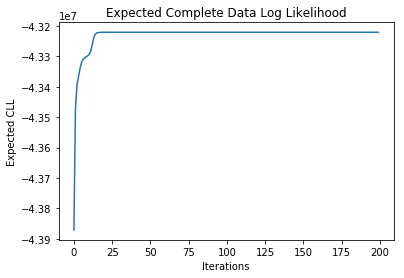

In [9]:
plt.title('Expected Complete Data Log Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Expected CLL')
plt.plot(cll_logs_batch_5)

## Cluster Mean Images

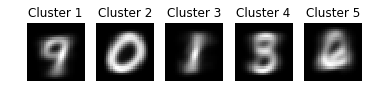

In [10]:
plot_images(cluster_mean_batch_5,(1,5))

## 10 Clusters

In [10]:
cluster_mean_batch_10, global_variance_batch_10, cluster_probs_batch_10, cll_logs_batch_10 = batch_em_gmm(mnist_x, num_clusters=10)

Iteration 200 Expected CLL : -42828508.360569194


## Expected CLL Plot

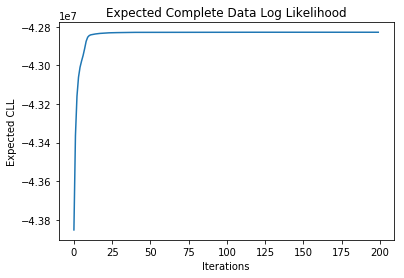

In [11]:
plt.title('Expected Complete Data Log Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Expected CLL')
plt.plot(cll_logs_batch_10)

## Cluster Mean Images

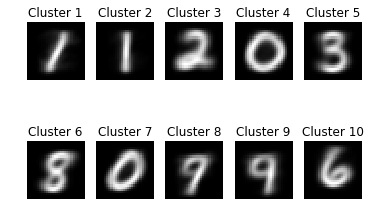

In [12]:
plot_images(cluster_mean_batch_10, (2,5))

## 15 Clusters

In [13]:
cluster_mean_batch_15, global_variance_batch_15, cluster_probs_batch_15, cll_logs_batch_15 = batch_em_gmm(mnist_x, num_clusters=15)

Iteration 200 Expected CLL : -42572704.673980705


## Expected CLL Plot

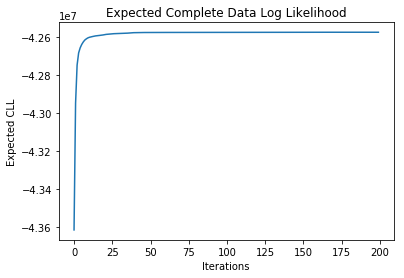

In [14]:
plt.title('Expected Complete Data Log Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Expected CLL')
plt.plot(cll_logs_batch_15)

## Cluster Mean Images

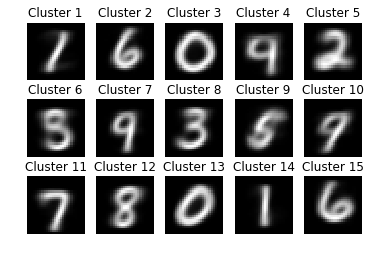

In [15]:
plot_images(cluster_mean_batch_15, (3,5))

## 20 Clusters

In [16]:
cluster_mean_batch_20, global_variance_batch_20, cluster_probs_batch_20, cll_logs_batch_20 = batch_em_gmm(mnist_x, num_clusters=20)

Iteration 200 Expected CLL : -42391062.09771285


## Expected CLL Plot

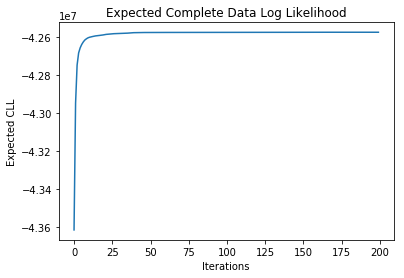

In [17]:
plt.title('Expected Complete Data Log Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Expected CLL')
plt.plot(cll_logs_batch_15)

## Cluster Mean Images

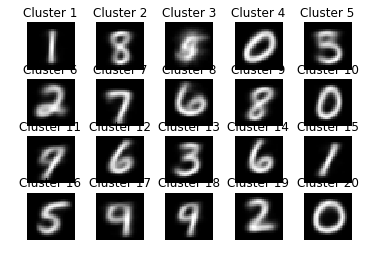

In [18]:
plot_images(cluster_mean_batch_20, (4, 5))

# Online EM Algorithm

The implementation is similar to the batch EM algorithm, except this time a random batch of examples are chosen every timestep and the parameters of the model are computed for that batch. The parameter updates, following the standard rule of online EM takes a convex combination of the older parameters and the parameters computed on the current minibatch governed by a time decaying learning rate. 

As the complete expected CLL for the entire dataset is not available, the CLL for the current batch is computed. This causes some stochasticity in the plots of the expected CLL, but there is a general increasing trend as expected

In [1]:
def online_em_gmm(dataset, num_clusters=5, num_itr=200, batch_size=100, kappa=0.55, logging=True):   
    
    assert num_clusters <= dataset.shape[0]
    
    # Initialize Cluster Means, Variances and cluster probabilities
    data_mean = np.mean(dataset, axis=0)
    data_var = np.var(dataset)
    
    cluster_means = np.array([data_mean * 3 * np.random.rand(784) for i in range(num_clusters)])
    global_variance = data_var * (2 + np.random.rand(1))
    cluster_prob = np.exp(np.array([i for i in range(num_clusters)]))
    cluster_prob /= np.sum(cluster_prob)
    
    cll_logs = []
    for itr in range(num_itr):
        # Select a random batch of examples
        X = dataset[np.random.randint(low=0, high=len(dataset) - 1, size=batch_size)]
        num_data, data_dim = X.shape
        
        # E Step: Calculate the required probability gamma_nk = p(c_n = k | theta, x_n) where c_n is the cluster assignment of x_n for the current batch
        log_gammas = np.zeros((num_clusters, num_data))
        for k in range(num_clusters):
            log_gammas[k] = log_gauss(X, cluster_means[k], global_variance) + np.log(cluster_prob[k])
        gammas = softmax(log_gammas.T)
        sum_gammas = np.sum(gammas, axis=0, keepdims=True)[0]
        
        # M Step : Parameter Estimation of cluster probabilities Pi_k using gamma_nk on the current batch
        cluster_prob_batch = sum_gammas / num_data
        gammas = gammas.T
        
        # M Step : Parameter Estimation of cluster means mu_k and the global / shared variance sigma_k
        cluster_means_batch = np.zeros(cluster_means.shape)
        global_variance_batch = 0.0
        for k in range(num_clusters):
            gamma_k = np.expand_dims(gammas[k], axis=1)
            cluster_means_batch[k] = np.sum(gamma_k * X, axis=0) / sum_gammas[k]
            dif_k = np.sum((X - cluster_means[k])**2, axis=1, keepdims=True)
            global_variance_batch += np.sum(gamma_k * dif_k, axis=0)/(num_data * data_dim) 
        
        # alpha_t = (1 + t)^-kappa
        # Parameters updated by the standard Online EM update rule
        #theta_t = (1 - alpha_t)theta_(t-1) + alpha_t * theta_batch
        lr = (2 + itr)**(-kappa)
        cluster_means = (1 - lr) * cluster_means + lr*cluster_means_batch
        cluster_prob = (1 - lr) * cluster_prob + lr*cluster_prob_batch
        global_variance = (1 - lr) * global_variance + lr*global_variance_batch
        
        # Likelihood of the current batch is computed. This has some inherent stochasticity and does not increase monotonically like the expected CLL
        cll = 0.0
        for k in range(num_clusters):
            cll += np.sum(gammas[k] * (log_gauss(X, cluster_means_batch[k], global_variance_batch) + np.log(cluster_prob_batch[k])))
        
        if logging is True:
            print('\rIteration {} Expected CLL of Current Batch : {}'.format(itr+1, cll), end='')
        
        cll_logs.append(cll)
    
    if logging is True:
        print('')
    return cluster_means, global_variance, cluster_prob, cll_logs

## 5 Clusters

In [20]:
cluster_means, global_variance, cluster_prob, cll_logs = online_em_gmm(mnist_x, num_clusters=5, batch_size=100)

Iteration 200 Expected CLL of Current Batch : -430003.3108345734


## Mini Batch Log Likelihood Plot

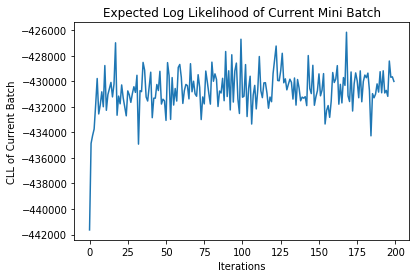

In [21]:
plt.title('Expected Log Likelihood of Current Mini Batch')
plt.xlabel('Iterations')
plt.ylabel('CLL of Current Batch')
plt.plot(cll_logs)

## Cluster Mean Images

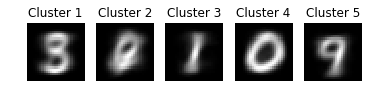

In [22]:
plot_images(cluster_means,(1,5))

## 10 Clusters

In [23]:
cluster_means, global_variance, cluster_prob, cll_logs = online_em_gmm(mnist_x, num_clusters=10, batch_size=100)

Iteration 200 Expected CLL of Current Batch : -424132.45257767173


## Mini Batch Log Likelihood Plot

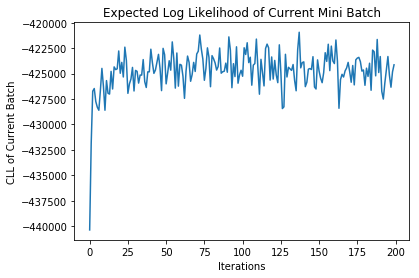

In [24]:
plt.title('Expected Log Likelihood of Current Mini Batch')
plt.xlabel('Iterations')
plt.ylabel('CLL of Current Batch')
plt.plot(cll_logs)

## Cluster Mean Images

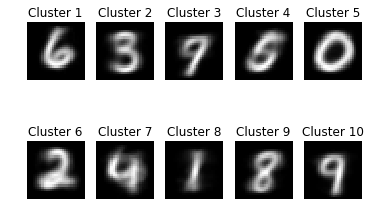

In [25]:
plot_images(cluster_means,(2,5))

## 15 Clusters

In [26]:
cluster_means, global_variance, cluster_prob, cll_logs = online_em_gmm(mnist_x, num_clusters=15, batch_size=100)

Iteration 200 Expected CLL of Current Batch : -420984.46755271114


## Mini Batch Log Likelihood Plot

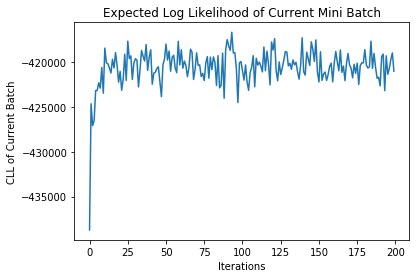

In [27]:
plt.title('Expected Log Likelihood of Current Mini Batch')
plt.xlabel('Iterations')
plt.ylabel('CLL of Current Batch')
plt.plot(cll_logs)

## Cluster Mean Images

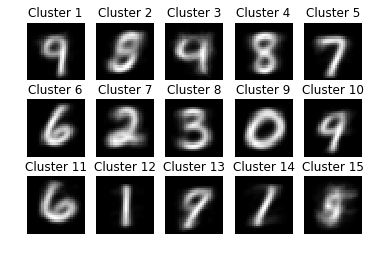

In [28]:
plot_images(cluster_means,(3,5))

## 20 Clusters

In [29]:
cluster_means, global_variance, cluster_prob, cll_logs = online_em_gmm(mnist_x, num_clusters=20, batch_size=100)

Iteration 200 Expected CLL of Current Batch : -414746.82499291335


## Mini Batch Log Likelihood Plot

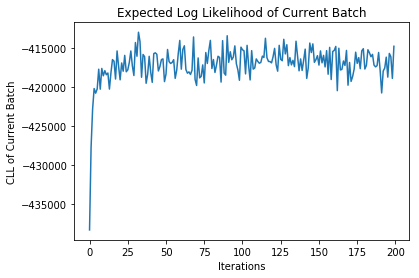

In [30]:
plt.title('Expected Log Likelihood of Current Batch')
plt.xlabel('Iterations')
plt.ylabel('CLL of Current Batch')
plt.plot(cll_logs)

## Cluster Mean Images

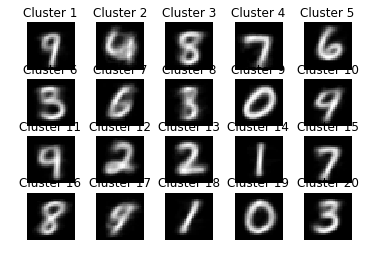

In [31]:
plot_images(cluster_means,(4,5))